/var/folders/24/dhffcc6s3hv3z0j3fbnd3tj80000gn/T/ipykernel_31232/636478047.py:677: UserWarning:

Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



/Users/johannesschmidt/Documents/Masterarbeit/.conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1813: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.

/Users/johannesschmidt/Documents/Masterarbeit/.conda/lib/python3.10/site-packages/scipy/stats/_morestats.py:1948: RuntimeWarning:

invalid value encountered in divide



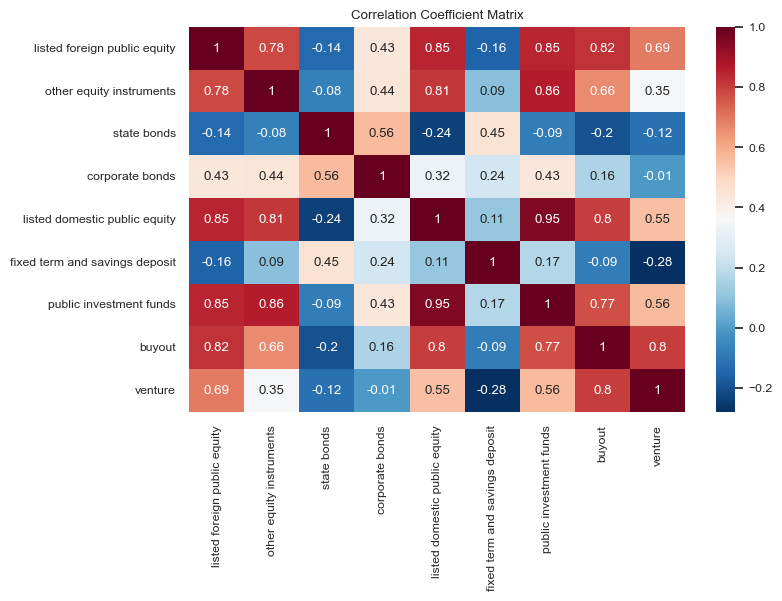

,Asset_classes,Weights
0,buyout,27.27%
1,state bonds,25.01%
2,corporate bonds,16.15%
3,fixed term and savings deposit,14.75%
4,cash,13.06%
5,listed foreign public equity,1.07%
6,public investment funds,0.92%
7,venture,0.7%
8,listed domestic public equity,0.61%
9,other equity instruments,0.47%


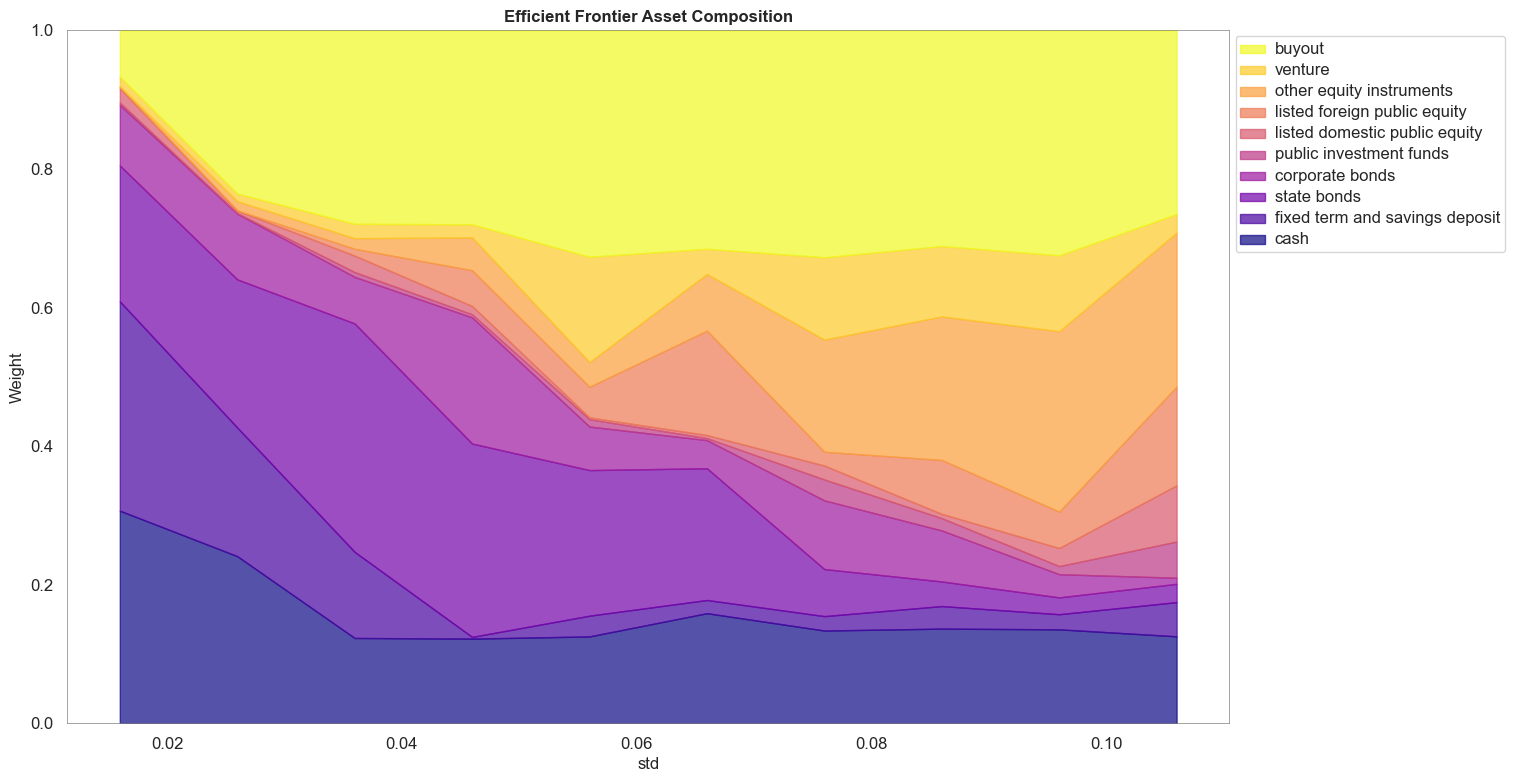

In [11]:
# Standard Libraries
import math
import random

# Numerical and Scientific Libraries
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis, jarque_bera, shapiro, anderson
import scipy.integrate as integrate
import scipy.special as special

# Data Analysis and Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Interactive Data Visualization Libraries
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

# Other Libraries
from IPython.display import display, HTML
from tqdm import tqdm as tqdm
import os
from scipy.interpolate import CubicSpline


##     ##               #######                                                                                                             
##      ##              #     #                                                                                                             
##       ##             #        #######  #######           #     #  #######  #######     #     #######  ######   #        #######  ####### 
##       ##             #######  #           #              #     #  #     #  #     #     #     #     #  #    #   #        #        #       
##       ##                  ##  ####        #               #   #   #######  #######     #     #######  #######  #        ####     ####### 
##      ##              #    ##  #           #                # #    #     #  #    #      #     #     #  #     #  #        #              # 
##     ##               #######  #######     #                 #     #     #  #    ##     #     #     #  #######  #######  #######  #######


# Define year range that should be incorporated
time_start = 2001
time_end = 2022

# Asset classes that are included either directly or as risk/return proxy into German Retail Investor Portfolio
retail_asset_classes = ['Listed Foreign Public Equity','Other Equity Instruments','State Bonds','Corporate Bonds','Listed Domestic Public Equity','Fixed Term and Savings Deposit','Public Investment Funds','Cash']

# Define max weight per asset class for restricted portfolio optimization
max_weight = 0.33

# Define cash for restricted portfolio optimization
cash_level = 0.428


# Define number of shots per Monte Carlo Simulation
n_unrestricted = 10000000
n_restricted = 10000000

# Define risk free rate for Sharpe calc.
risk_free_rate=0.016 

# Define CVaR-Threshold
CVaR_threshold = 0.1

# To load caches, name the optimization model parameters
# Variable or fixed cash
var_cash= True

# Inclusion of alternatives
alt=True

# Version of results
version = '_4'

# Choose asset classes for portfolio optimization
if alt == True:
    asset_classes_ex1 = ['Listed Foreign Public Equity','Other Equity Instruments','State Bonds','Corporate Bonds','Listed Domestic Public Equity','Fixed Term and Savings Deposit','Public Investment Funds','Cash','BUYOUT','VENTURE']

    illiquidity_data = {
        'Illiquidity_index': [0.25, 0.25, 0, 0, 0.25, 0, 0.25, 0, 1, 1]
    }
    illiquidity_table = pd.DataFrame(illiquidity_data, index=[
        'listed foreign public equity', 'other equity instruments', 'state bonds','corporate bonds','listed domestic public equity','fixed term and savings deposit', 'public investment funds',
        'cash', 'buyout','venture'
    ])
else:
    asset_classes_ex1 = ['Listed Foreign Public Equity','Other Equity Instruments','State Bonds','Corporate Bonds','Listed Domestic Public Equity','Fixed Term and Savings Deposit','Public Investment Funds','Cash']

    illiquidity_data = {
        'Illiquidity_index': [0.25, 0.25, 0, 0, 0.25, 0, 0.25, 0]
    }
    illiquidity_table = pd.DataFrame(illiquidity_data, index=[
        'listed foreign public equity', 'other equity instruments', 'state bonds','corporate bonds','listed domestic public equity','fixed term and savings deposit', 'public investment funds',
        'cash'
    ])

# Activate model
active_classes = asset_classes_ex1.copy()





#######   ##               ######                                                                           #######                                                                                  
#######    ##              #                                                                                #     #                                                                                  
     ##     ##             #        #     #  #     #  #######  #######     #     #######  #     #           #     #  #######  #######     #     #     #     #     #######     #     #######  #     # 
#######     ##             #####    #     #  ##    #  #           #        #     #     #  ##    #           ##    #  #        #           #     ##    #     #        #        #     #     #  ##    # 
##          ##             ##       #     #  # ### #  #           #        #     #     #  # ### #           ##    #  ####     ####        #     # ### #     #        #        #     #     #  # ### # 
#######    ##              ##       #     #  #    ##  #           #        #     #     #  #    ##           ##    #  #        #           #     #    ##     #        #        #     #     #  #    ## 
#######   ##               ##       #######  #     #  #######     #        #     #######  #     #           #######  #######  #           #     #     #     #        #        #     #######  #     # 
                                                                                                                                                                                                      

# Calculate Bayes_Steins estimates using the shrikage factor w
def bayes_stein_returns(matrix, adjust=True):


    t, n = matrix.shape
    sample_means = matrix.mean(axis=0)
    ones = np.ones_like(sample_means)

    E = np.cov(matrix, rowvar=False)
    # Zellner & Chetty adjustment of sample cov matrix
    adj_Z_C = (float(t) - 1) / (t - n - 2)
    E *= round(adj_Z_C, 4) 
    I = np.linalg.inv(E)
    grand_mean = sample_means.dot(I).dot(ones.T) / ones.dot(I).dot(ones.T)
    diff = sample_means - grand_mean
    denominator = n + 2 + diff.dot(t*I).dot(diff.T)
    w = round((n + 2) / denominator, 4)
    #print('The weighting coefficient in Bayes-Stein shrinkage: {}'.format(w))
    adjusted_means = (1 - w)*sample_means + w*grand_mean

    return adjusted_means

# Define a function to calculate CVaR at a given confidence level
def calculate_cvar(data, alpha):
    sorted_returns = np.sort(data)
    var_index = int((1 - alpha) * len(sorted_returns))
    cvar = -sorted_returns[:var_index].mean()
    return cvar

def calc_risk_return_measures (tickers_list,weights_list,where_index,selected_returns,label):    
    
    alloc_df = pd.DataFrame(weights_list[where_index],tickers_list[where_index],columns=['Allocation'])

    # Get the column order from selected_returns dataframe
    column_order = selected_returns.columns

    # Reindex alloc_df based on the column order
    alloc_df = alloc_df.reindex(column_order)

    selected_returns_local = selected_returns.copy()

    # Calculate weighted returns
    selected_returns_local['weighted_returns'] = (selected_returns * alloc_df['Allocation']).sum(axis=1)
    
    # Return estimators

    selected_means = selected_returns_local['weighted_returns'].mean()
    selected_medians = selected_returns_local['weighted_returns'].median()

    # Calculate the annual geometric mean for each asset
    geometric_mean = (selected_returns_local['weighted_returns'] + 1).prod()**(1 / len(selected_returns_local['weighted_returns'])) - 1

    # Bayes-Stein (shrinkage)

    weighted_returns = (selected_returns * alloc_df['Allocation'])

    # Calculate the portfolio illiquidity index
    portfolio_illiquidity = np.sum(alloc_df['Allocation'] * illiquidity_table['Illiquidity_index'])

    # Marginal illiquidity penalty funciton
    def exponential_function(x):
        b = np.log(4) / 0.2
        return (0.05 / np.exp(0.4 * (np.log(4) / 0.2))) * np.exp(b * x)

    # Calculate the illiquidity punishment as the area under the function from 0 to the portfolio illiquidity
    illiquidity_punishment, _ = integrate.quad(exponential_function, 0, portfolio_illiquidity)


    # drop cash as 0 const otherwise the matrix cannot be inverted
    # Find the index number of the column 'cash'
    index_cash = weighted_returns.columns.get_loc('cash')
    selected_returns_wo_cash = weighted_returns.drop(columns='cash')
    selected_bayes_stein_returns = bayes_stein_returns(selected_returns_wo_cash)
    # Create a new Series with the "cash" asset class and its corresponding return value
    cash_series = pd.Series([0.0], index=["cash"])
    # Concatenate the new_series with the original selected_bayes_stein_returns series
    selected_bayes_stein_returns = pd.concat([selected_bayes_stein_returns.iloc[:index_cash], cash_series, selected_bayes_stein_returns.iloc[index_cash:]])
    bayes_stein_return = sum(selected_bayes_stein_returns)

    # Risk estimators

    selected_skewness = selected_returns_local['weighted_returns'].skew()
    selected_kurtosis = selected_returns_local['weighted_returns'].kurtosis()
    selected_std_dev = selected_returns_local['weighted_returns'].std()
    selected_cvar = calculate_cvar(selected_returns_local['weighted_returns'], 1- CVaR_threshold)

    return selected_means, selected_medians, geometric_mean, bayes_stein_return, selected_skewness, selected_kurtosis, selected_std_dev, selected_cvar,illiquidity_punishment

def calc_retail_risk_return_measures (retail_asset_allocation,selected_returns):    
    
    if alt == True:
    
        columns_to_exclude = ['venture', 'buyout']

        # Drop the specified columns
        selected_columns_df = selected_returns.drop(columns=columns_to_exclude)
    
    else:
        selected_columns_df = selected_returns.copy()
    
    # Get the column order from selected_returns dataframe
    column_order = selected_columns_df.columns

    # Reindex alloc_df based on the column order
    retail_asset_allocation = retail_asset_allocation.reindex(column_order)

    selected_returns_local = selected_columns_df.copy()

    # Calculate weighted returns
    selected_returns_local['weighted_returns'] = (selected_returns * retail_asset_allocation['Allocation']).sum(axis=1)
    
    # Return estimators

    selected_means = selected_returns_local['weighted_returns'].mean()
    selected_medians = selected_returns_local['weighted_returns'].median()

    # Calculate the portfolio illiquidity index
    portfolio_illiquidity = np.sum(retail_asset_allocation['Allocation'] * illiquidity_table['Illiquidity_index'])

    # Marginal illiquidity penalty funciton
    def exponential_function(x):
        b = np.log(4) / 0.2
        return (0.05 / np.exp(0.4 * (np.log(4) / 0.2))) * np.exp(b * x)

    # Calculate the illiquidity punishment as the area under the function from 0 to the portfolio illiquidity
    illiquidity_punishment, _ = integrate.quad(exponential_function, 0, portfolio_illiquidity)

    # Calculate the annual geometric mean for each asset
    geometric_mean = (selected_returns_local['weighted_returns'] + 1).prod()**(1 / len(selected_returns_local['weighted_returns'])) - 1

    # Bayes-Stein (shrinkage)

    weighted_returns = (selected_columns_df * retail_asset_allocation['Allocation'])
    # drop cash as 0 const otherwise the matrix cannot be inverted
    # Find the index number of the column 'cash'
    index_cash = weighted_returns.columns.get_loc('cash')
    selected_returns_wo_cash = weighted_returns.drop(columns='cash')
    selected_bayes_stein_returns = bayes_stein_returns(selected_returns_wo_cash)
    # Create a new Series with the "cash" asset class and its corresponding return value
    cash_series = pd.Series([0.0], index=["cash"])
    # Concatenate the new_series with the original selected_bayes_stein_returns series
    selected_bayes_stein_returns = pd.concat([selected_bayes_stein_returns.iloc[:index_cash], cash_series, selected_bayes_stein_returns.iloc[index_cash:]])
    bayes_stein_return = sum(selected_bayes_stein_returns)

    # Risk estimators

    selected_skewness = selected_returns_local['weighted_returns'].skew()
    selected_kurtosis = selected_returns_local['weighted_returns'].kurtosis()
    selected_std_dev = selected_returns_local['weighted_returns'].std()
    selected_cvar = calculate_cvar(selected_returns_local['weighted_returns'], 1- CVaR_threshold)

    return selected_means, selected_medians, geometric_mean, bayes_stein_return, selected_skewness, selected_kurtosis, selected_std_dev, selected_cvar, illiquidity_punishment

# Function to plot the simulated portfolios with the minimum variance port., highest sharpe port. and retail portfolio
def plot_ef  (mean_variance_pairs,tickers_list,weights_list,risk_free_rate,retail_return,retail_std,title_name,selected_returns,retail_asset_allocation): 
    #-- Plot the risk vs. return of randomly generated portfolios
    #-- Convert the list from before into an array for easy plotting
    mean_variance_pairs = np.array(mean_variance_pairs)


    fig = go.Figure()
    fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                        marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                    showscale=True, 
                                    size=7,
                                    line=dict(width=1),
                                    colorscale="RdBu",
                                    colorbar=dict(title="Sharpe<br>Ratio")
                                    ), 
                        mode='markers',
                        text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
    fig.update_layout(template='plotly_white',
                    xaxis=dict(title='Annualised Risk (Volatility)'),
                    yaxis=dict(title='Annualised Return'),
                    title=title_name,
                    width=1000,
                    height=700,
                    showlegend = False)

    #-- Find the portfolio with the highest Sharpe ratio
    sharpe_ratio = (mean_variance_pairs[:,0]-risk_free_rate) / (mean_variance_pairs[:,1]**0.5)
    max_sharpe_idx = np.argmax(sharpe_ratio)
    max_sharpe_weights = weights_list[max_sharpe_idx]
    max_sharpe_tickers = tickers_list[max_sharpe_idx]
    max_sharpe_return = np.round(mean_variance_pairs[max_sharpe_idx][0] * 100,decimals=2)
    max_sharpe_risk = np.round(mean_variance_pairs[max_sharpe_idx][1]**0.5 * 100,decimals=2)

    max_sharpe_mean, max_sharpe_median, max_sharpe_geometric_mean, max_sharpe_bayes_stein_return, max_sharpe_skewness, max_sharpe_kurtosis, max_sharpe_std_dev, max_sharpe_cvar, max_sharpe_illiquidity_punishment = calc_risk_return_measures(tickers_list,weights_list,max_sharpe_idx,selected_returns,'max_sharpe')
    

    #-- Find the portfolio with the minimum variance
    min_var_idx = np.argmin(mean_variance_pairs[:,1])
    min_var_weights = weights_list[min_var_idx]
    min_var_tickers = tickers_list[min_var_idx]
    min_var_return = np.round(mean_variance_pairs[min_var_idx][0] * 100,decimals=2)
    min_var_risk = np.round(mean_variance_pairs[min_var_idx][1]**0.5 * 100,decimals=2)

    min_var_mean, min_var_median, min_var_geometric_mean, min_var_bayes_stein_return, min_var_skewness, min_var_kurtosis, min_var_std_dev, min_var_cvar,min_var_illiquidity_punishment = calc_risk_return_measures(tickers_list,weights_list,min_var_idx,selected_returns,'min_var')

    #-- Find the portfolio with the closest risk measure
    # Convert mean_variance_pairs_re into a NumPy array
    mean_variance_pairs_array = np.array(mean_variance_pairs)

    # Extract the standard deviation array
    std_array = np.sqrt(mean_variance_pairs_array[:, 1])

    # Find the indices of the pairs within the specified range
    indices_within_range = np.where(((retail_std - std_array) >= 0) & ((retail_std - std_array) <= 0.001))[0]

    # If there are indices within the range, select the last one (closest to the lower end of the range)
    if indices_within_range.size > 0:
        closest_index = indices_within_range[-1]
        closest_std_tickers = tickers_list_re[closest_index]
        closest_std_weights = weights_list_re[closest_index]
    else:
        # Handle the case where no pairs are within the specified range
        closest_std_tickers = None
        closest_std_weights = None



    closest_risk_mean, closest_risk_median, closest_risk_geometric_mean, closest_risk_bayes_stein_return, closest_risk_skewness, closest_risk_kurtosis, closest_risk_std_dev, closest_risk_cvar, closest_risk_illiquidity_punishment = calc_risk_return_measures(tickers_list,weights_list,closest_index,selected_returns,'risk_match')


    #-- Take the portfolio stats of the average German private houshold portfolio
    # Extract the index as an array
    retail_tickers = retail_asset_allocation.index.str.lower().to_numpy()
    retail_weights = retail_asset_allocation['Allocation'].to_numpy()

    retail_asset_allocation.index = retail_asset_allocation.index.str.lower()

    retial_risk_mean, retial_risk_median, retial_risk_geometric_mean, retial_risk_bayes_stein_return, retial_risk_skewness, retial_risk_kurtosis, retial_risk_std_dev, retial_risk_cvar, retial_illiquidity_punishment = calc_retail_risk_return_measures(retail_asset_allocation,selected_returns)


    #-- Add the portfolios to the scatter plot
    fig.add_trace(go.Scatter(x=[mean_variance_pairs[max_sharpe_idx,1]**0.5], y=[mean_variance_pairs[max_sharpe_idx,0]], 
                            marker=dict(color='green', size=10), 
                            mode='markers', 
                            name=None,
                            text=['Portfolio with highest Sharpe ratio (' + str(np.array(max_sharpe_tickers)) + ', ' + str(np.array(max_sharpe_weights).round(2)) + ')']))

    fig.add_trace(go.Scatter(x=[mean_variance_pairs[min_var_idx,1]**0.5], y=[mean_variance_pairs[min_var_idx,0]], 
                            marker=dict(color='red', size=10), 
                            mode='markers', 
                            name=None,
                            text=['Minimum variance portfolio (' + str(np.array(min_var_tickers)) + ', ' + str(np.array(min_var_weights).round(2)) + ')']))

    fig.add_trace(go.Scatter(x = [retail_std], y= [retail_return], 
                            marker=dict(color='purple', size=10), 
                            mode='markers', 
                            name=None,
                            text=['Retail Investor Portfolio (' + str(np.array(retail_tickers)) + ', ' + str(np.array(retail_weights).round(2)) + ')']))


    #-- Add the efficient frontier line from the risk-free rate to the portfolio with the highest Sharpe ratio
    ef_line_x = np.linspace(0, max(mean_variance_pairs[:,1]**0.5), 100)
    ef_line_y = ef_line_x * sharpe_ratio[max_sharpe_idx] + risk_free_rate
    fig.add_trace(go.Scatter(x=ef_line_x, y=ef_line_y, 
                            line=dict(color='black', width=2, dash='dash'),
                            name='Efficient Frontier'))


    # Plot the three relevant highlight portfolios with their assigned weights below
    max_sharpe_df = pd.DataFrame({'Asset_classes': max_sharpe_tickers, 'Weights': max_sharpe_weights})
    max_sharpe_df = max_sharpe_df.sort_values('Weights', ascending=False)
    max_sharpe_df['Weights'] = (max_sharpe_df['Weights'] * 100).round(2).astype(str) + '%'

    min_var_df = pd.DataFrame({'Asset_classes': min_var_tickers, 'Weights': min_var_weights})
    min_var_df = min_var_df.sort_values('Weights', ascending=False)
    min_var_df['Weights'] = (min_var_df['Weights'] * 100).round(2).astype(str) + '%'

    closest_std_df = pd.DataFrame({'Asset_classes': closest_std_tickers, 'Weights': closest_std_weights})
    closest_std_df = closest_std_df.sort_values('Weights', ascending=False)
    closest_std_df['Weights'] = (closest_std_df['Weights'] * 100).round(2).astype(str) + '%'
    closest_std_return = np.round(mean_variance_pairs[closest_index][0] * 100,decimals=2)
    closest_std_risk = np.round(mean_variance_pairs[closest_index][1]**0.5 * 100,decimals=2)

    # Transform retail portfolio ret and std. for plot
    retail_return = np.round(retail_return * 100,decimals=2)
    retail_std = np.round(retail_std * 100,decimals=2)

    retail_asset_allocation_df = retail_asset_allocation.copy()
    retail_asset_allocation_df = retail_asset_allocation_df.sort_values('Allocation', ascending=False)
    retail_asset_allocation_df['Allocation'] = (retail_asset_allocation['Allocation'] * 100).round(2).astype(str) + '%'
    retail_asset_allocation_df.reset_index(inplace=True)
    retail_asset_allocation_df.rename(columns={'Asset Class': 'Asset_classes', 'Allocation': 'Weights'},inplace = True)
    retail_asset_allocation_df['Asset_classes'] = retail_asset_allocation_df['Asset_classes'].str.lower()

    # remove index of max_sharpe_df and min_var_df
    max_sharpe_df = max_sharpe_df.reset_index(drop=True)
    min_var_df = min_var_df.reset_index(drop=True)
    closest_std_df = closest_std_df.reset_index(drop=True)


    # define CSS styles for the table
    styles = [
        dict(selector="th", props=[("text-align", "center"), ("font-family", "Poppins")]),
        dict(selector="td", props=[("text-align", "center"), ("font-family", "Poppins")]),
    ]

    # create HTML code for the dataframes with 
    max_sharpe_html = f"<div style='display: inline-block; vertical-align: top; margin-right: 20px;'><h3 style='font-family: Poppins; font-size: 130%;'>Max Sharpe</h3>Return: {max_sharpe_return}%, Std.: {max_sharpe_risk}% <br><br>Median: {round((max_sharpe_median * 100),2)}%,Geo. Mean: {round((max_sharpe_geometric_mean * 100),2)}%, Bayes Stein: {round((max_sharpe_bayes_stein_return * 100),2)}%, Ill. penalized: {round((max_sharpe_return - max_sharpe_illiquidity_punishment * 100),2)}%, Skewness: {round((max_sharpe_skewness),2)}, Kurtosis: {round((max_sharpe_kurtosis),2)}, CVaR: {round((max_sharpe_cvar * 100),2)}% <br><br>{max_sharpe_df.style.set_table_styles(styles).to_html(index=False)}</div>"
    min_var_html = f"<div style='display: inline-block; vertical-align: top; margin-right: 20px;'><h3 style='font-family: Poppins; font-size: 130%;'>Min Variance</h3>Return: {min_var_return}%, Std.: {min_var_risk}% <br><br>Median: {round((min_var_median * 100),2)}%,Geo. Mean: {round((min_var_geometric_mean * 100),2)}%, Bayes Stein: {round((min_var_bayes_stein_return * 100),2)}%, Ill. penalized: {round((min_var_return - min_var_illiquidity_punishment * 100),2)}%, Skewness: {round((min_var_skewness),2)}, Kurtosis: {round((min_var_kurtosis),2)}, CVaR: {round((min_var_cvar * 100),2)}% <br><br>{min_var_df.style.set_table_styles(styles).to_html(index=False)}</div>"
    closest_std_html = f"<div style='display: inline-block; vertical-align: top; margin-right: 20px;'><h3 style='font-family: Poppins; font-size: 130%;'>Risk Matching Portfolio</h3>Return: {closest_std_return}%, Std.: {closest_std_risk}% <br><br>Median: {round((closest_risk_median * 100),2)}%,Geo. Mean: {round((closest_risk_geometric_mean * 100),2)}%, Bayes Stein: {round((closest_risk_bayes_stein_return * 100),2)}%, Ill. penalized: {round((closest_std_return - closest_risk_illiquidity_punishment * 100),2)}%, Skewness: {round((closest_risk_skewness),2)}, Kurtosis: {round((closest_risk_kurtosis),2)}, CVaR: {round((closest_risk_cvar * 100),2)}% <br><br>{closest_std_df.style.set_table_styles(styles).to_html(index=False)}</div>"
    retail_html = f"<div style='display: inline-block; vertical-align: top;'><h3 style='font-family: Poppins; font-size: 130%;'>Retail Portfolio</h3>Return: {retail_return}%, Std.: {retail_std}% <br><br>Median: {round((retial_risk_median * 100),2)}%,Geo. Mean: {round((retial_risk_geometric_mean * 100),2)}%, Bayes Stein: {round((retial_risk_bayes_stein_return * 100),2)}%, Ill. penalized: {round((retail_return - retial_illiquidity_punishment * 100),2)}%, Skewness: {round((retial_risk_skewness),2)}, Kurtosis: {round((retial_risk_kurtosis),2)}, CVaR: {round((retial_risk_cvar * 100),2)}% <br><br>{retail_asset_allocation_df.style.set_table_styles(styles).to_html(index=False)}</div>"

    # Return the outputs
    return fig,max_sharpe_html,min_var_html,closest_std_html,retail_html


def plot_ef_composition (tickers_list, weights_list, mean_variance_pairs,title):
    # Create a set of unique tickers from tickers_list_un
    unique_tickers = set([ticker for sublist in tickers_list for ticker in sublist])

    # Initialize an empty dictionary to store column values
    column_values = {ticker: [] for ticker in unique_tickers}

    # Iterate through tickers_list_un and weights_list_un simultaneously
    for tickers, weights in zip(tickers_list, weights_list):
        ticker_weight_pairs = zip(tickers, weights)
        
        # Update the column values dictionary based on ticker and weight pairs
        for ticker, weight in ticker_weight_pairs:
            column_values[ticker].append(weight)

    # Create the weighted_allocation DataFrame
    weighted_allocation = pd.DataFrame(column_values)

    # If there are missing values, replace them with 0
    weighted_allocation.fillna(0, inplace=True)

    # Sort the columns in alphabetical order
    weighted_allocation = weighted_allocation.reindex(sorted(weighted_allocation.columns), axis=1)


    mean_variance_pairs = pd.DataFrame(mean_variance_pairs, columns=['Return', 'Variance'])

    # Calculate standard deviation (std) for each portfolio using the variance
    mean_variance_pairs['Std'] = np.sqrt(mean_variance_pairs['Variance'])

    # Create a new dataframe to store efficient portfolio compositions
    efficient_portfolios = pd.DataFrame(columns=column_values)

    # Define std intervals with a fixed distance of 0.001
    std_intervals = np.arange(mean_variance_pairs['Std'].min(), mean_variance_pairs['Std'].max(), 0.01)

    # Iterate over std intervals and find the efficient portfolio composition with the highest return
    for std in std_intervals:
        portfolios_within_interval = mean_variance_pairs[
            (mean_variance_pairs['Std'] >= std) & (mean_variance_pairs['Std'] < std + 0.002)]
        if len(portfolios_within_interval) > 0:
            max_return_index = portfolios_within_interval['Return'].idxmax()
            efficient_portfolios.loc[std] = weighted_allocation.iloc[max_return_index]

    efficient_portfolios.index.name = 'std'

    # Get the number of assets
    num_assets = len(efficient_portfolios.columns)

    # Generate a color palette with evenly spaced hues
    colors = plt.cm.plasma(np.linspace(0, 1, num_assets))

    # Set up the figure and axes with a larger size
    fig, ax = plt.subplots(figsize=(15, 9))

    # Rearrange the columns of the efficient_portfolios DataFrame
    if alt == True:
        new_order = [
            'cash',
            'fixed term and savings deposit',
            'state bonds',
            'corporate bonds',
            'public investment funds',
            'listed domestic public equity',
            'listed foreign public equity',
            'other equity instruments',
            'venture',
            'buyout'
        ]
    else:
        new_order = [
            'cash',
            'fixed term and savings deposit',
            'state bonds',
            'corporate bonds',
            'public investment funds',
            'listed domestic public equity',
            'listed foreign public equity',
            'other equity instruments'
        ]        
    efficient_portfolios = efficient_portfolios.reindex(new_order, axis=1)

    # Loop through each asset
    for i, asset in enumerate(efficient_portfolios.columns):
    
        # Get the weights for the current asset
        weights = efficient_portfolios[asset]

        # Calculate the bottom position for each asset's polygon
        bottom = efficient_portfolios.iloc[:, :i].sum(axis=1)

        # Plot the filled polygon for each level of std, with stacking
        ax.fill_between(efficient_portfolios.index, bottom, bottom + weights, color=colors[i], alpha=0.7, label=asset)


    # Set the x-axis label
    ax.set_xlabel('std', fontsize=12)

    # Set the y-axis label
    ax.set_ylabel('Weight', fontsize=12)

    # Set the y-axis limits to range from 0 to 1 (0% to 100%)
    ax.set_ylim(0, 1)

    # Retrieve the current handles and labels from the legend
    handles, labels = ax.get_legend_handles_labels()

    # Reverse the order of the handles and labels
    reversed_handles = handles[::-1]
    reversed_labels = labels[::-1]

    # Create a new legend with the reversed labels and handles
    legend = ax.legend(reversed_handles, reversed_labels, loc='upper left', bbox_to_anchor=(1, 1),facecolor = 'white')

    # Customize the legend labels for better readability
    for text in legend.get_texts():
        text.set_fontsize(12)  # Set the font size
        #text.set_fontweight('bold')  # Set the font weight

    # Customize tick label font size for both x and y axes
    ax.tick_params(axis='both', labelsize=12)

    ax.set_facecolor(color='white')

    ax.spines['left'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['bottom'].set_color('0.5')

    spine_width = 0.5  # Adjust this value as needed
    ax.spines['top'].set_linewidth(spine_width)
    ax.spines['bottom'].set_linewidth(spine_width)
    ax.spines['left'].set_linewidth(spine_width)
    ax.spines['right'].set_linewidth(spine_width)

    ax.set_title("Efficient Frontier Asset Composition", fontsize=12, fontweight='bold')


    
    # Show the plot
    plt.show()

def load_caches (var_cash,alt):
    
    core_lit = ''
    data_pipe = ''
    if (var_cash == False and alt == False):
        core_lit = '/Fixed_cash_No_alt'
        data_pipe = '1'
    elif (var_cash == True and alt == False):
        core_lit = '/Var_cash_No_alt'
        data_pipe = '2'
    elif (var_cash == True and alt == True):
        core_lit = '/Var_cash_With_alt'
        data_pipe = '3'

    
    path = os.path.abspath("../Results")


    # Import portfolio simulation caches
    mean_variance_pairs_re = path + core_lit + '_RE_' + data_pipe + '_pairs'+ version
    mean_variance_pairs_re = pd.read_csv(mean_variance_pairs_re,delimiter=',', decimal='.')
    mean_variance_pairs_re.drop(mean_variance_pairs_re.columns[0], axis=1, inplace=True)
    mean_variance_pairs_re = mean_variance_pairs_re.values.tolist()


    tickers_list_re = path + core_lit + '_RE_' + data_pipe + '_tickers'+ version
    tickers_list_re = pd.read_csv(tickers_list_re,delimiter=',', decimal='.')
    tickers_list_re.drop(tickers_list_re.columns[0], axis=1, inplace=True)
    tickers_list_re = tickers_list_re.values.tolist()


    weights_list_re = path + core_lit + '_RE_' + data_pipe + '_weights'+ version
    weights_list_re = pd.read_csv(weights_list_re,delimiter=',', decimal='.')
    weights_list_re.drop(weights_list_re.columns[0], axis=1, inplace=True)
    weights_list_re = weights_list_re.values.tolist()

    return mean_variance_pairs_re,tickers_list_re,weights_list_re

## function to load, transform and create data set
def data_loader (time_start,time_end,retail_asset_classes):


    #######   ##                                                                                                                 
    #######    ##                                                                                                                
        ##     ##                #     #     #  #######  #######  #######  #######           ######   #######  #######  ####### 
        ####     ##                #     ##   ##  #     #  #     #  #     #     #              #     #  #     #     #     #     # 
        ##     ##                #     # # # #  #######  #     #  #######     #              #     #  #######     #     ####### 
    #######    ##                 #     #  #  #  #        #     #  #    #      #              #     #  #     #     #     #     # 
    #######   ##                  #     #     #  #        #######  #    ##     #              ######   #     #     #     #     # 


    # Import quarterly index data from Preqin
    preqin_quarter_file = '/Users/johannesschmidt/Documents/Masterarbeit/Data/preqin_export_Private Capital Quarterly Index Chart_2023_5_12.csv'
    preqin_data_quarter = pd.read_csv(preqin_quarter_file,delimiter=';', decimal=',')

    # Import Bloomberg data
    bloomberg_file = '/Users/johannesschmidt/Documents/Masterarbeit/Data/Bloomberg_selected_data.csv'
    bloomberg_data = pd.read_csv(bloomberg_file,delimiter=';', decimal=',')

    # Import DAX from Yahoo Finance
    dax_file = '/Users/johannesschmidt/Documents/Masterarbeit/Data/^GDAXI.csv'
    dax_data = pd.read_csv(dax_file,delimiter=',', decimal='.')
    # Import SDAX
    sdax_file = '/Users/johannesschmidt/Documents/Masterarbeit/Data/SDAX Historical Data (1).csv'
    sdax = pd.read_csv(sdax_file,delimiter=',', decimal='.')

    # Import Fixed_term_and_savings_deposit returns from Deutsche Bundesbank
    savings_file = '/Users/johannesschmidt/Documents/Masterarbeit/Data/Fixed_Term_and_Savings_Deposit_Deutsche_Bundesbank.csv'
    savings_data = pd.read_csv(savings_file,delimiter=';', decimal=',')

    # Import Investment fund data from Rifinitiv
    Investment_fund_file = '/Users/johannesschmidt/Documents/Masterarbeit/Data/German_Investment_funds.csv'
    Investment_fund_data = pd.read_csv(Investment_fund_file,delimiter=';', decimal=',')


    # Create a dictionary with the asset allocation (incl. similar risk/return proxies) of German Private Housholds in 2022
    houshold_data = {
    'Asset Class': ['Listed Foreign Public Equity','Other Equity Instruments','State Bonds','Corporate Bonds','Listed Domestic Public Equity','Fixed Term and Savings Deposit','Public Investment Funds','Cash'],
    'Allocation': ['5%', '8.4%', '0.73%', '1.46%', '5.9%', '17.1%', '18.6%','42.8%']
    }

    # Create the dataframe
    retail_asset_allocation = pd.DataFrame(houshold_data)


    ##   ##   ##                                                                                                                                   
    ##   ##    ##                                                                                                                                  
    ##   ##     ##             ######   #######  #######  #######           #######  #        #######  #######  #     #     #     #     #  ####### 
    # #####     ##             #     #  #     #     #     #     #           #        #        #        #     #  ##    #     #     ##    #  #       
        ##     ##             #     #  #######     #     #######           #        #        ####     #######  # ### #     #     # ### #  #  #### 
        ##    ##              #     #  #     #     #     #     #           #        #        #        #     #  #    ##     #     #    ##  #     # 
        ##   ##               ######   #     #     #     #     #           #######  #######  #######  #     #  #     #     #     #     #  #######


    # PREQIN QUARTERLY DATA
    # drop the first row
    preqin_data_quarter = preqin_data_quarter.drop(0)

    # set the new column titles
    preqin_data_quarter.columns = preqin_data_quarter.iloc[0]
    preqin_data_quarter = preqin_data_quarter.drop(1)

    # reset the index
    preqin_data_quarter = preqin_data_quarter.reset_index(drop=True)

    preqin_data_quarter['DATE'] = pd.to_datetime(preqin_data_quarter['DATE'], format='%b-%y') + pd.offsets.MonthEnd(0)
    preqin_data_quarter['DATE'] = preqin_data_quarter['DATE'].dt.strftime('%d.%m.%Y')

    # set the date column as the index
    preqin_data_quarter = preqin_data_quarter.set_index('DATE')

    # convert the index to a DatetimeIndex
    preqin_data_quarter.index = pd.to_datetime(preqin_data_quarter.index)

    # replace commas with dots in all columns
    preqin_data_quarter = preqin_data_quarter.replace(',', '.', regex=True)

    # convert the values to numbers
    preqin_data_quarter = preqin_data_quarter.apply(pd.to_numeric)

    # calculate the quarterly returns
    preqin_quarterly_returns = preqin_data_quarter.resample('Q').last().pct_change()

    # drop the first row of the quarterly_returns DataFrame
    preqin_quarterly_returns = preqin_quarterly_returns.drop(preqin_quarterly_returns.index[0])

    # Filter rows based on year condition
    # Convert start and end to pd.datetime format
    preqin_start = pd.to_datetime(str(time_start))
    preqin_end = pd.to_datetime(str(time_end+1))

    # Create a boolean mask based on the condition
    mask = (preqin_quarterly_returns.index >= preqin_start) & (preqin_quarterly_returns.index <= preqin_end)

    # Filter the DataFrame using the boolean mask
    preqin_quarterly_returns = preqin_quarterly_returns[mask]


    # Convert the "Date" column to datetime
    bloomberg_data['Date'] = pd.to_datetime(bloomberg_data['Date'], format='%d.%m.%Y')

    # Set the "Date" column as the index
    bloomberg_data.set_index('Date', inplace=True)

    # Convert the index to a DatetimeIndex
    bloomberg_data.index = pd.to_datetime(bloomberg_data.index)

    # Filter rows based on year condition
    # Convert start and end to pd.datetime format
    x = pd.to_datetime(str(time_start))
    y = pd.to_datetime(str(time_end+1))

    # Create a boolean mask based on the condition
    mask = (bloomberg_data.index >= x) & (bloomberg_data.index <= y)

    bloomberg_data = bloomberg_data[mask]

    bloomberg_data.drop(bloomberg_data.columns[[0, 2]], axis=1, inplace=True)

    # Rename the columns
    bloomberg_data.rename(columns={
        '% Change': 'Bloomberg Euro Aggregate Corporate Total Return Index EU',
        '% Change.1': 'Bloomberg Euro Aggregate Treasury Germany Total Return Index'
    }, inplace=True)

    # Divide all columns by 100
    bloomberg_data = bloomberg_data / 100

    # Invert rows
    bloomberg_data = bloomberg_data.iloc[::-1]
    bloomberg_returns = bloomberg_data.copy()


    # DAX DATA
    # First, we need to convert the "Date" column to a datetime type
    dax_data['Date'] = pd.to_datetime(dax_data['Date'])

    # Set the "Date" column as the index of the DataFrame
    dax_data.set_index('Date', inplace=True)

    # Create an empty DataFrame to store the monthly returns
    dax_monthly_rets = pd.DataFrame(columns=['Year', 'DAX'])

    # Calculate and populate the monthly returns
    months = dax_data.resample('M').agg({'Close': ['last']})
    # Shift the 'Close' column one row to get the previous month's 'Close' price
    months['Previous_Close'] = months['Close'].shift(1)

    # Calculate the monthly return as the percentage change in 'Close' prices
    months['DAX'] = (months['Close','last'] / months['Previous_Close'] - 1)
    months.drop(columns=['Previous_Close','Close'], inplace=True)

    dax_monthly_rets = months.copy()

    # Filter rows based on year condition
    # Convert start and end to pd.datetime format
    x = pd.to_datetime(str(time_start))
    y = pd.to_datetime(str(time_end+1))

    # Create a boolean mask based on the condition
    mask = (dax_monthly_rets.index >= x) & (dax_monthly_rets.index <= y)

    # Filter the DataFrame using the boolean mask
    dax_monthly_rets = dax_monthly_rets[mask]

    # Remove the second heading level of the multi-level index
    dax_monthly_rets.columns = dax_monthly_rets.columns.droplevel(1)
    
    pd.set_option('display.max_rows', None)

    # SDAX DATA
    # Step 1: Select the first two columns
    sdax = sdax[['Date', 'Price']]

    # Step 2: Parse the Date column to datetime
    sdax['Date'] = pd.to_datetime(sdax['Date'], format='%m/%d/%Y')

    # Step 3: Set the Date column as the index
    sdax.set_index('Date', inplace=True)

    # Step 4: Remove commas and convert Price column to numeric
    sdax['SDAX'] = pd.to_numeric(sdax['Price'].str.replace(',', ''), errors='coerce')

    # Drop the original 'Price' column
    sdax.drop(columns=['Price'], inplace=True)

    # Step 5: Calculate monthly returns
    sdax_monthly_returns = sdax['SDAX'].resample('M').first().pct_change()

    # Adjust the monthly returns to represent the return for the current month
    sdax_monthly_returns.index = sdax_monthly_returns.index + pd.DateOffset(months=-1)

    # Step 6: Filter rows based on the year condition
    # Convert start and end to pd.datetime format
    x = pd.to_datetime(str(time_start), format='%Y')
    y = pd.to_datetime(str(time_end+1), format='%Y')

    # Create a boolean mask based on the condition
    temp_mask = (sdax_monthly_returns.index >= x) & (sdax_monthly_returns.index <= y)

    # Filter the DataFrame using the boolean mask
    sdax_monthly_rets = sdax_monthly_returns[temp_mask]




    # SAVINGS AND DEPOSIT DATA
    # Convert Year and Month columns to datetime format and add last day of the month
    savings_data['Date'] = pd.to_datetime(savings_data[['Year', 'Month']].assign(day=1)).dt.to_period('M').dt.to_timestamp('M') + pd.offsets.MonthEnd(0)

    # Calculate savings_returns based on the provided formula
    savings_data['savings_returns'] = (savings_data['Return, % p.a.'] / 12) * 0.01

    # Select only the Date and savings_returns columns for the final DataFrame
    savings_monthly = savings_data[['Date', 'savings_returns']]

    # Set the 'Year' column as the index
    savings_monthly = savings_monthly.set_index('Date')

    # Create a boolean mask based on the condition
    mask = (savings_monthly.index >= x) & (savings_monthly.index <= y)
    savings_monthly = savings_monthly[mask]


    # Investment Fund
    # Delete the first row
    Investment_fund_data = Investment_fund_data.iloc[1:]

    # Typecast the first column to pd.datetime and name it 'date'
    Investment_fund_data['Date'] = pd.to_datetime(Investment_fund_data.iloc[:, 0], format='%d-%b-%Y')

    # Set 'date' column as the index
    Investment_fund_data.set_index('Date', inplace=True)

    # Delete the first column where the old date format is stored‘
    Investment_fund_data = Investment_fund_data.iloc[:, 1:]

    # Create a new column named 'Investment_Funds' with average return per row
    Investment_fund_data['Investment_Funds'] = Investment_fund_data.mean(axis=1)

    investment_fund_return = pd.DataFrame(Investment_fund_data['Investment_Funds'])

    investment_fund_return = investment_fund_return.drop(investment_fund_return.index[0])
    investment_fund_return = investment_fund_return.drop(investment_fund_return.index[0])

    # Filter rows based on time condition
    investment_fund_return = investment_fund_return.loc[(investment_fund_return.index >= x)& (investment_fund_return.index <= y)]



    #######   ##                                                                                                                                                                       
    #######    ##                                                                                                                                                                      
    #           ##             ######   #######  #######  #######           #######  #######  #######           #######  #######  #######  #######  #######     #     #######  #     # 
    #######     ##             #     #  #     #     #     #     #           #        #           #              #        #     #  #        #     #     #        #     #     #  ##    # 
        ##     ##             #     #  #######     #     #######           #######  ####        #              #        #######  ####     #######     #        #     #     #  # ### # 
    #######    ##              #     #  #     #     #     #     #                 #  #           #              #        #    #   #        #     #     #        #     #     #  #    ## 
    #######   ##               ######   #     #     #     #     #           #######  #######     #              #######  #    ##  #######  #     #     #        #     #######  #     # 




    ## SET Creation ##

    ## Monthly return set##
    dax_monthly_rets = dax_monthly_rets.reset_index()

    # Reset index and drop "Date" column for sdax
    sdax_monthly_rets = sdax_monthly_rets.reset_index().drop(columns=['Date'])

    # Reset index and drop "Date" column for investment_fund_return
    investment_fund_return_reset = investment_fund_return.reset_index().drop(columns=['Date'])

    # Reset index and drop "Date" column for bloomberg_returns
    bloomberg_returns_reset = bloomberg_returns.reset_index().drop(columns=['Date'])

    # Reset index and drop "Date" column for savings_returns
    savings_monthly_reset = savings_monthly.reset_index().drop(columns=['Date'])

    # Concatenate the columns of the three dataframes
    monthly_returns = pd.concat([dax_monthly_rets, sdax_monthly_rets, investment_fund_return_reset, bloomberg_returns_reset,savings_monthly_reset], axis=1)



    ## Quarterly return set##

    # Step 2: Set the 'Date' column as the index
    monthly_returns.set_index('Date', inplace=True)

    combined_quarterly = monthly_returns.groupby(pd.Grouper(freq='Q')).apply(lambda x: (1 + x).prod() - 1)

    # Preqin-----------
    # Reset index and drop "Date" column for bloomberg_returns
    preqin_quarterly_returns_reset = preqin_quarterly_returns.reset_index().drop(columns=['DATE'])

    # Concatenate the columns of the three dataframes

    combined_quarterly_reset = combined_quarterly.reset_index()
    quarterly_returns = pd.concat([combined_quarterly_reset, preqin_quarterly_returns_reset], axis=1)

    # Add CASH as a 0-constant
    quarterly_returns['CASH'] = 0.00


    # Define a dictionary to map the old column names to the new column names
    column_mapping = {
    'S&P 500 TOTAL RETURN': 'Listed Foreign Public Equity',
    'SDAX': 'Other Equity Instruments',
    'Bloomberg Euro Aggregate Treasury Germany Total Return Index': 'State Bonds',
    'Bloomberg Euro Aggregate Corporate Total Return Index EU': 'Corporate Bonds',
    'DAX': 'Listed Domestic Public Equity',
    'savings_returns': 'Fixed Term and Savings Deposit',
    'Investment_Funds': 'Public Investment Funds',
    'CASH': 'Cash'
    }

    # Rename the columns using the column_mapping dictionary
    quarterly_returns = quarterly_returns.rename(columns=column_mapping)


    ## Annual return set ##


    # Create annual return set by grouping by year and summing the quarterly returns to get annual returns, taking into account the compounding effect within each year.
    # Set the 'Date' column as the index
    quarterly_returns.set_index('Date', inplace=True)

    annual_returns = quarterly_returns.groupby(pd.Grouper(freq='Y')).apply(lambda x: (1 + x).prod() - 1)

    # Convert index to datetime format and extract year
    annual_returns.index = pd.to_datetime(annual_returns.index).year

    # Rename the index to 'Year'
    annual_returns.index.name = 'Year'


    # GERMAN RETIAL INVESTOR PORTFOLIO CREATION


    # Select the desired columns from the dataframe
    retail_annual_returns = annual_returns[retail_asset_classes]

    # Transform the Allocation column to floats
    retail_asset_allocation['Allocation'] = retail_asset_allocation['Allocation'].str.rstrip('%').astype(float) / 100

    # Set 'Asset Class' as the index
    retail_asset_allocation.set_index('Asset Class', inplace=True)

    # Calculate weighted returns
    weighted_returns = retail_annual_returns.mul(retail_asset_allocation['Allocation'], axis=1)

    # Calculate the weighted average return per year
    retail_annual_returns['RETURN'] = weighted_returns.sum(axis=1)

    # Calculate standard deviation and mean return
    retail_std = retail_annual_returns['RETURN'].std()
    retail_return = retail_annual_returns['RETURN'].mean()

    return annual_returns, quarterly_returns, retail_asset_allocation, retail_annual_returns, retail_return, retail_std


#######   ##                                                                                                                                                                                                                    
#######    ##                                                                                                                                                                                                                   
##          ##             ######   #######  #######  #######  #######     #     #######  #######     #     #     #  #######           #######  #######  #######  #######     #     #######  #######     #     #######  ####### 
#######     ##             #     #  #        #        #        #     #     #     #     #     #        #     #     #  #                 #           #     #     #     #        #     #           #        #     #        #       
##   ##     ##             #     #  ####     #######  #        #######     #     #######     #        #      #   #   ####              #######     #     #######     #        #     #######     #        #     #        ####### 
#######    ##              #     #  #              #  #        #    #      #     #           #        #       # #    #                       #     #     #     #     #        #           #     #        #     #              # 
#######   ##               ######   #######  #######  #######  #    ##     #     #           #        #        #     #######           #######     #     #     #     #        #     #######     #        #     #######  ####### 

# Load data set
annual_returns, quarterly_returns, retail_asset_allocation, retail_annual_returns, retail_return, retail_std = data_loader(time_start,time_end,retail_asset_classes)

# Define colors for the chart
colors = ['#FFDC26', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#1F77B4', '#17becf', '#7F7F7F']

# Plot the retail asset allocation chart
fig = go.Figure(data=[go.Pie(labels=retail_asset_allocation.index, values=retail_asset_allocation['Allocation'], hole=0.4, marker=dict(colors=colors))])

# Set the aspect ratio to make the plot square-sized
fig.update_layout(
    width=600,
    height=600,
    legend=dict(orientation='h', y=-0.2)
)
# Set the axis labels and plot title
fig.update_layout(
    title='Retail Allocation Plot'
)

fig.show()

# Drop Return column
retail_annual_returns.drop(columns=['RETURN'],inplace=True)

# Convert the column names (x-axis labels) to lowercase for retail_annual_returns
annual_returns.columns = annual_returns.columns.str.lower()
quarterly_returns.columns = quarterly_returns.columns.str.lower()

# Select asset classes
active_classes = [element.lower() for element in active_classes]
selected_returns = annual_returns[active_classes]
selected_quarterly_returns = quarterly_returns[active_classes]

# Calculate summary statistics for each asset class
stats = pd.DataFrame(index=['mean', 'median', 'std', 'skewness', 'kurtosis'])
for col in selected_quarterly_returns.columns:
    selected_quarterly_returns[col] = selected_quarterly_returns[col].astype(float)
    selected_returns[col] = selected_returns[col].astype(float)
    mean = selected_returns[col].mean()
    median = selected_returns[col].median()
    std = selected_quarterly_returns[col].std() * np.sqrt(4)
    skewness_value = skew(selected_quarterly_returns[col])
    kurtosis_value = kurtosis(selected_quarterly_returns[col])
    stats[col] = [mean, median, std, skewness_value, kurtosis_value]

# Convert the column names (x-axis labels) to lowercase
stats.columns = stats.columns.str.lower()

# How many assests in the portfolio
n_assets = selected_returns.shape[1]

# transpose the table
stats_selected = stats.T
# Rename Index to asset_class
stats_selected.rename_axis('asset_class',inplace=True)
mus = (stats_selected['mean'])

# Covariance matrix of the asset classes based on annualized quarterly returns
cov = selected_quarterly_returns.cov() * 4

# Create a scatter plot for return/risk analysis
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=stats_selected['std'],
    y=stats_selected['mean'],
    mode='markers',
    marker=dict(
        size=10,
        color='blue',
        symbol='circle'
    )
))

# Set the aspect ratio to make the plot square-sized
fig.update_layout(
    width=600,
    height=600
)

# Set the axis labels and plot title
fig.update_layout(
    xaxis=dict(title='Standard Deviation'),
    yaxis=dict(title='Mean'),
    title='Risk-Return Plot'
)

# Add annotations for each asset class
annotations = [
    dict(
        x=x_val,
        y=y_val,
        xref="x",
        yref="y",
        text=asset,
        showarrow=True,
        arrowhead=7,
        ax=0,
        ay=-40
    )
    for asset, x_val, y_val in zip(stats_selected.index, stats_selected['std'], stats_selected['mean'])
]

fig.update_layout(
    annotations=annotations
)

# Show the plot
fig.show()



custom_color_palette = px.colors.qualitative.Plotly

fig = px.line(selected_returns, x=selected_returns.index, y=selected_returns.columns, 
              labels={"x": "Year", "y": "Returns"}, title="Returns Over Time",color_discrete_sequence=custom_color_palette)

# Update the legend title
fig.update_layout(legend_title_text="Asset Class")

# Customize layout
fig.update_layout(
    plot_bgcolor="white",  # Set background color to white
    xaxis=dict(showgrid=False, tickvals=selected_returns.index, ticktext=selected_returns.index,),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
    width=2000,
    height=600 
)


# Add a box around the plot
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper",
            yref="paper",
            x0=0,
            y0=0,
            x1=1,
            y1=1,
            line=dict(color="black", width=1),
        )
    ]
)
fig.update_layout(yaxis_title="Returns")


fig.show()



# Return estimators

selected_means = selected_returns.mean()
selected_medians = selected_returns.median()

# Calculate the annual geometric mean for each asset
geometric_means = (selected_returns + 1).prod()**(1 / len(selected_returns)) - 1

# Bayes-Stein (shrinkage)
# drop cash as 0 const otherwise the matrix cannot be inverted
# Find the index number of the column 'cash'
index_cash = selected_returns.columns.get_loc('cash')
selected_returns_wo_cash = selected_returns.drop(columns='cash')
selected_bayes_stein_returns = bayes_stein_returns(selected_returns_wo_cash)
# Create a new Series with the "cash" asset class and its corresponding return value
cash_series = pd.Series([0.0], index=["cash"])
# Concatenate the new_series with the original selected_bayes_stein_returns series
selected_bayes_stein_returns = pd.concat([selected_bayes_stein_returns.iloc[:index_cash], cash_series, selected_bayes_stein_returns.iloc[index_cash:]])


# Risk estimators

selected_skewness = selected_returns.skew()
selected_kurtosis = selected_returns.kurtosis()
selected_std_dev = selected_returns.std()
selected_cvar = selected_returns.apply(calculate_cvar, alpha=0.9)


# Normality Tests
# Perform Jarque-Bera test
selected_jb = selected_returns.apply(lambda x: jarque_bera(x)[0])
selected_jb_p = selected_returns.apply(lambda x: jarque_bera(x)[1])
# Perform Shapiro-Wilk test
selected_sw = selected_returns.apply(lambda x: shapiro(x)[0])
selected_sw_p = selected_returns.apply(lambda x: shapiro(x)[1])
# Perform Anderson-Darling test
selected_ad = selected_returns.apply(lambda x: anderson(x, dist='norm')[0])
# Create an empty dictionary to store the significance levels
significance_levels = {}

# Iterate over each column in the DataFrame
for column in selected_returns.columns:
    # Perform the Anderson-Darling normality test on the column
    result = anderson(selected_returns[column])
    
    # Extract the critical values and significance levels
    critical_values = result.critical_values
    significance = result.significance_level
    
    # Find the index at which the null hypothesis can be rejected
    rejection_index = next((i for i, cv in enumerate(critical_values) if result.statistic > cv), None)
    
    # If rejection index is found, find the corresponding significance level
    if rejection_index is not None:
        rejection_level = significance[rejection_index]
    else:
        rejection_level = None
    
    # Store the significance level in the dictionary
    significance_levels[column] = rejection_level
series_modified =  pd.Series(significance_levels).fillna(-1).astype(int) / 100
series_modified[series_modified == -0.01] = np.nan

# Create a DataFrame to store the results
comparison_df = pd.DataFrame({
    ('Return','Mean'): selected_means,
    ('Return','Median'): selected_medians,
    ('Return','Geometric Mean'): geometric_means,
    ('Return','Bayes Stein'): selected_bayes_stein_returns,
    ('Risk','Standard Dev.'): selected_std_dev,
    ('Risk','Skewness'): selected_skewness,
    ('Risk','Kurtosis'): selected_kurtosis,
    ('Risk','CVaR'): selected_cvar,
    ('Normality Tests', 'Jarque-Bera') : selected_jb,
    ('Normality Tests', 'p-value') : selected_jb_p,
    ('Normality Tests', 'Shapiro-Wilk') : selected_sw,
    ('Normality Tests', 'p-value ') : selected_sw_p,
    ('Normality Tests', 'Anderson-Darling') : selected_ad,
    ('Normality Tests', 'sig.') : series_modified
})

comparison_df_save = comparison_df.copy()

# Sort the DataFrame by geometric mean in descending order
comparison_df = comparison_df.sort_values(('Return','Mean'), ascending=False).round(decimals=2)

# Apply the formatting function to all cells in the DataFrame
#comparison_df = comparison_df.applymap(format_number)


# Apply color scale to each column in ascending order
comparison_df = comparison_df.style.format(precision=2, na_rep="n/a").background_gradient(axis=0)


comparison_df = comparison_df.set_table_styles([
    {'selector': 'th.col_heading.level0', 'props': [('text-align', 'center')]}
])

# Add vertical black lines to separate columns 3 and 4, and columns 8 and 9
table_styles = [
    {'selector': 'th.col_heading.level0', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level3', 'props': [('border-right', '1px solid black')]},
    {'selector': 'th.col_heading.level8', 'props': [('border-right', '1px solid black')]},
]

comparison_df = comparison_df.set_table_styles(table_styles)

# Display the styled DataFrame
display(comparison_df)

# Plot Correlation Map

# Select all columns except cash
selected_returns_without_cash = selected_returns.loc[:, selected_returns.columns != 'cash']

# Compute the correlation matrix using the Pearson method
corr = selected_returns_without_cash.corr(method='pearson').round(decimals=2)

# Set figure size
plt.figure(figsize=(8,5))

# Generate a heatmap of the correlation matrix

sns.set(font_scale=0.8)
ax = sns.heatmap(corr, cmap='RdBu_r', annot=True)
ax.set_title('Correlation Coefficient Matrix')

# Show the plot
plt.show()

##################  LOAD CACHES ########################

# mean_variance_pairs_un,tickers_list_un,weights_list_un,mean_variance_pairs_re,tickers_list_re,weights_list_re = load_caches(var_cash=var_cash,alt=alt)
mean_variance_pairs_re,tickers_list_re,weights_list_re = load_caches(var_cash=var_cash,alt=alt)

# Plot Portfolio Optimization with EF, and allocations

# Set of input parameters
title_name_re = 'Efficient Frontier of Restricted Portfolio'
fig2, max_sharpe_html2, min_var_html2, closest_std_html2, retail_html2 = plot_ef(mean_variance_pairs_re, tickers_list_re, weights_list_re, risk_free_rate,retail_return,retail_std,title_name_re,selected_returns,retail_asset_allocation)



fig2.show()
# Display the combined HTML code
display(HTML(max_sharpe_html2 + min_var_html2 + closest_std_html2 + retail_html2))


plot_ef_composition(tickers_list=tickers_list_re,weights_list=weights_list_re,mean_variance_pairs=mean_variance_pairs_re,title = 'EF Composition of restricted Portfolio Optimization')


## Wealth Development

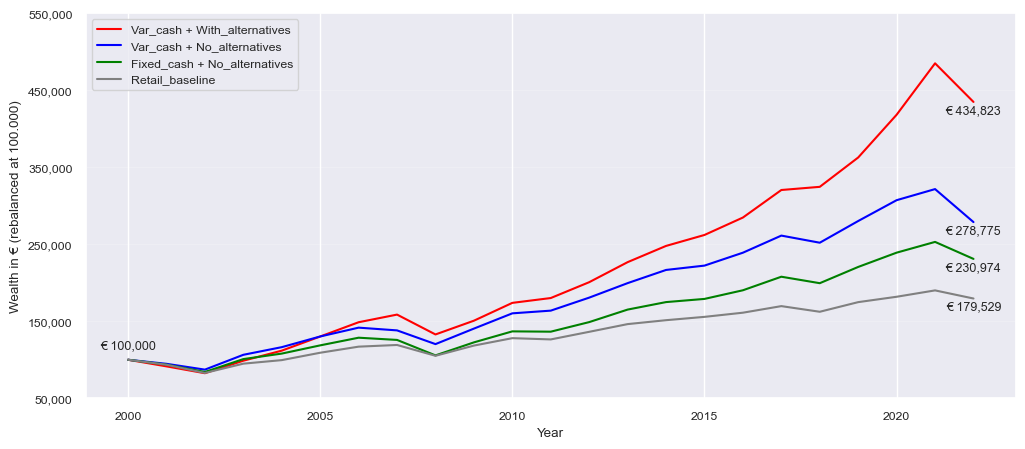

In [47]:
# Data
years = [2000,2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

# Data retrieved from the selected_returns dataframe output
wealth_without_alternatives = [
    100000,
    94725.8,
    87166.87061,
    106430.3132,
    116352.8113,
    130223.4626,
    141687.1643,
    138131.8082,
    120311.2855,
    140446.5823,
    160270.8983,
    163784.998,
    180672.214,
    199506.5696,
    216625.6298,
    222265.9113,
    239032.7626,
    261240.5795,
    251991.3568,
    280184.4018,
    307231.4426,
    321632.9165,
    278775.0087,
]
wealth_with_alternatives=[
    100000,
    91399.9,
    82514.82432,
    98762.24077,
    111812.1895,
    130185.9511,
    148724.5607,
    158643.0017,
    132857.4855,
    150715.923,
    173868.9031,
    180145.7443,
    200727.2155,
    226750.2946,
    247828.7752,
    262062.5731,
    284695.8693,
    320448.546,
    324561.503,
    362682.2253,
    418213.9515,
    484977.6267,
    434823.1805
]
wealth_retail = [
    100000.00,
    93526.80,
    82853.43,
    94914.40,
    99513.29,
    109101.29,
    117009.50,
    119190.68,
    105149.06,
    118406.57,
    128040.01,
    126396.75,
    136273.77,
    146284.16,
    151375.58,
    155693.42,
    161109.06,
    169646.39,
    162318.01,
    174825.91,
    181803.73,
    190075.80,
    179528.88
]
wealth_fixed_cash_no_alternatives = [
    100000.00,
    93719.30,
    84123.10,
    100854.85,
    108003.24,
    118673.09,
    128630.95,
    125747.56,
    105668.95,
    122566.47,
    136859.55,
    136460.06,
    148891.85,
    165150.39,
    174879.07,
    179006.56,
    190237.79,
    207830.41,
    199427.42,
    220538.60,
    239089.87,
    253040.52,
    230973.62 
]

# Create the plot
plt.figure(figsize=(12, 5))
plt.plot(years, wealth_with_alternatives, label='Var_cash + With_alternatives', linestyle='-', color='red', linewidth=1.5)
plt.plot(years, wealth_without_alternatives, label='Var_cash + No_alternatives', linestyle='-', color='blue', linewidth=1.5)
plt.plot(years, wealth_fixed_cash_no_alternatives, label='Fixed_cash + No_alternatives', linestyle='-', color='green', linewidth=1.5)
plt.plot(years, wealth_retail, label='Retail_baseline', linestyle='-', color='grey', linewidth=1.5)

# Add descriptions for the last values
plt.annotate(f'€ {wealth_with_alternatives[-1]:,.0f}', (years[-1], wealth_with_alternatives[-1]), textcoords="offset points", xytext=(0,-8), ha='center', fontsize=9)
plt.annotate(f'€ {wealth_without_alternatives[-1]:,.0f}', (years[-1], wealth_without_alternatives[-1]), textcoords="offset points", xytext=(0,-8), ha='center', fontsize=9)
plt.annotate(f'€ {wealth_retail[-1]:,.0f}', (years[-1], wealth_retail[-1]), textcoords="offset points", xytext=(0,-8), ha='center', fontsize=9)
plt.annotate(f'€ {wealth_fixed_cash_no_alternatives[-1]:,.0f}', (years[-1], wealth_fixed_cash_no_alternatives[-1]), textcoords="offset points", xytext=(0,-8), ha='center', fontsize=9)

# Format y-axis labels with "." as the thousand separator and 0 digits after the comma
ax = plt.gca()
ax.get_yaxis().set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Wealth in € (rebalanced at 100.000)')



# Set a step size to show every second y-axis value
y_ticks = plt.gca().get_yticks()
plt.gca().set_yticks(y_ticks[::2])


# Add legend
plt.legend()

# Add horizontal grid lines
plt.grid(axis='y', linestyle='-', alpha=0.2)

# Remove the outside box
#plt.box(on=None)

# Annotate the first initial values
initial_wealth_with_alternatives = f'€ {wealth_with_alternatives[0]:,.0f}'
plt.annotate(initial_wealth_with_alternatives, (years[0], wealth_with_alternatives[0]), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9)



# Show the plot
plt.show()